# Lesson 4 - TensorFlow and Convolutional Neural Networks

This last lesson introduces the main development framework for Artificial Neural Networks: Google's [TensorFlow](https://www.tensorflow.org) library.
TensorFlow provides many optimization algorithms, regularization techniques, high-level abstractions (e.g. *layers*) and also logging and visualization tools collected in the [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) suite.
We will take advantage of TensorFlow's API to describe the problem of regularization and the class of Convolutional Neural Networks.

### Summary

* [TensorFlow](#tensorflow)
* [The MNIST dataset](#mnist)
* [Building a model in TensorFlow](#tfmodel)
* [Overfitting and regularization](#overfitregularize)
* [Spatial locality and sparse connectivity](#sparseconnect)
* [Layers](#layers)


<a id=tensorflow></a>
### TensorFlow

TensorFlow was initially released in late 2015 to allow Machine Learning researchers to use a production-level framework for designing and testing their models.

Discussions about pros and cons with respect to other frameworks are left to dedicated [blog posts](https://deeplearning4j.org/compare-dl4j-tensorflow-pytorch).
A main point to use TensorFlow is that although it requires much effort to get confidence with, it pays off many times over due to its flexibility (passing from research models to deployment models is quite straightforward since the syntax is the same) and community support.

TensorFlow is based on the *dataflow* programming model which has been studied during the last two lessons.
This means that almost every action a programmer wants his program to do has to be thought to as an [**Operation**](https://www.tensorflow.org/api_docs/python/tf/Operation), while data is stored in [**Tensor**](https://www.tensorflow.org/api_docs/python/tf/Tensor) objects.

A tricky difference comes in when we talk about [**Variable**](https://www.tensorflow.org/api_docs/python/tf/Variable) objects: these class represents a wrapper of `tf.Operation`, `tf.Tensor` objects, and maintenance functions to allow TensorFlow to initialize, update, load and store parameters into them.
After all, what defines an Artificial Neural Network are its architecture and its parameters: maybe TensorFlow's implementation is not the most transparent one but, as already said, it comes with many advantages.


In [1]:
import tensorflow as tf
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

<a id=mnist></a>
### The MNIST dataset

The [MINST database](http://yann.lecun.com/exdb/mnist/) is a set of greyscale images of 28-by-28 pixels representing decimal digits from zero to nine.
It is composed by a training set containing 60000 examples and by a test set containing 10000 examples.

The problem is a multinomial logistic regression: a model $f_{\theta}: X \to Y$ should map images (points of $X$) to one of ten classes ($Y = \{0, 1, \dots 9\}$).

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

if sys.platform == 'win32':
    WORKING_DIRECTORY = '.\MNIST'
elif sys.platform == 'linux':
    WORKING_DIRECTORY = './MNIST'
    
def load_mnist(valid_frac=0.1):
    # load MNIST
    mnist = input_data.read_data_sets(os.path.join(WORKING_DIRECTORY, 'data'), one_hot=True)
    # load training data
    training_x = mnist.train.images
    training_y_hat = np.asarray(mnist.train.labels, dtype=np.int32)
    # separate training samples from validation samples
    num_train_samples = len(training_x)
    num_val_samples = int((1.0-valid_frac) * num_train_samples)
    train_x = training_x[:num_val_samples]
    train_y_hat = training_y_hat[:num_val_samples]
    valid_x = training_x[num_val_samples:]
    valid_y_hat = training_y_hat[num_val_samples:]
    # load test data
    test_x = mnist.test.images
    test_y_hat = np.asarray(mnist.test.labels, dtype=np.int32)
    
    return list(zip(train_x, train_y_hat)), list(zip(valid_x, valid_y_hat)), list(zip(test_x, test_y_hat))


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting .\MNIST\data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting .\MNIST\data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting .\MNIST\data\t10k-images-idx3-ubyte.gz
Extracting .\MNIST\data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


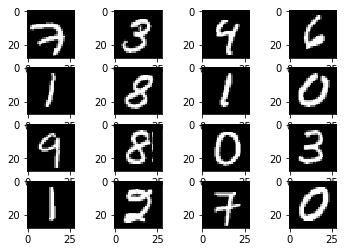

In [3]:
train, test, valid = load_mnist()

# plot first 16 images
num_rows = 4
num_cols = 4
fig1 = plt.figure()
for i in range(0, num_rows*num_cols):
    img = np.reshape(train[i][0], (28, 28))
    fig1.add_subplot(num_rows, num_cols, i+1)
    plt.imshow(img, cmap='gray')
plt.show()


<a id=tfmodel></a>
### Building a model in TensorFlow

TensorFlow programs should leverage Python's object-orientedness.

Each `model` class should have at least a private `__build` method (called by `__init__`) and public `train` and `infer` methods:
* the `__build` method should take care of assembling the computational graph, and may be decomposed in submethods corresponding to the mathematical transformations your model has been thinked to represent;
* to make it easier for other researchers to replicate the model you build and its respective training experiment, training data consumed by the `train` method should be retrieved and loaded by a specific private procedure `__load_data`;
* in contrast, it should be possible to pass whichever compatible inputs to the `infer` method, to allow quick tests on user-provided data.

This approach allows other researchers and engineers to:
* quickly reuse functions that define specific sequences of computational nodes, representing specific mathematical transformations;
* easily reproduce your ideas;
* quickly move from a research model to a deployment one.


In [4]:
class MNISTFullyConnected():
    def __init__(self, num_hidden):
        self.learning_rate = 0.001
        self.momentum = 0.8
        self.num_epochs = 1
        self.num_inputs = 784
        self.num_hidden = num_hidden
        self.num_outputs = 10
        self.__build(self.num_hidden)
        self.logdir = os.path.join(WORKING_DIRECTORY, 'fully_connected')
        self.saver = tf.train.Saver()
        
    def __load_data(self, valid_frac=0.1):
        # load MNIST
        mnist = input_data.read_data_sets(os.path.join(WORKING_DIRECTORY, 'data'), one_hot=True)
        # load training data
        training_x = mnist.train.images
        training_y_hat = np.asarray(mnist.train.labels, dtype=np.int32)
        # separate training samples from validation samples
        num_train_samples = len(training_x)
        num_val_samples = int((1.0-valid_frac) * num_train_samples)
        train_x = training_x[:num_val_samples]
        train_y_hat = training_y_hat[:num_val_samples]
        valid_x = training_x[num_val_samples:]
        valid_y_hat = training_y_hat[num_val_samples:]
        # load test data
        test_x = mnist.test.images
        test_y_hat = np.asarray(mnist.test.labels, dtype=np.int32)

        return list(zip(train_x, train_y_hat)), list(zip(valid_x, valid_y_hat)), list(zip(test_x, test_y_hat))
        
    def __build(self, num_hidden):
        logits = self.__core(num_hidden)
        self.__inference(logits)
        self.__training(logits)
        self.__testing()
        
    def __core(self, num_hidden):
        with tf.name_scope('input_layer') as scope:
            self.X = tf.placeholder(tf.float32, [None, self.num_inputs], name='image')
        with tf.name_scope('hidden_layer') as scope:
            w_h = tf.Variable(tf.truncated_normal((self.num_inputs, num_hidden)), name='weights')
            b_h = tf.Variable(tf.zeros((1, num_hidden)), name='bias')
            hidden_scores = tf.add(tf.matmul(self.X, w_h), b_h, name='linear')
            hidden_act = tf.sigmoid(hidden_scores, name='activation')
        with tf.name_scope('output_layer') as scope:
            w_out = tf.Variable(tf.truncated_normal((num_hidden, self.num_outputs)), name='weights')
            b_out = tf.Variable(tf.zeros((1, self.num_outputs)), name='bias')
            logits = tf.add(tf.matmul(hidden_act, w_out), b_out, name='logits')
            
        return logits
    
    def __inference(self, logits):
        with tf.name_scope('output_layer') as scope:
            probs = tf.nn.softmax(logits, name='probabilities')
            self.outputs = tf.argmax(probs, axis=0, name='prediction')

    def __training(self, logits):
        with tf.name_scope('labels') as scope:
            self.Y_hat = tf.placeholder(tf.int32, [None, self.num_outputs], name='label')
        with tf.name_scope('loss') as scope:
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=self.Y_hat, name='cross_entropy')
            self.loss = tf.reduce_mean(cross_entropy, name='loss')
            self.loss_summary = tf.summary.scalar('loss_log', self.loss)
        with tf.name_scope('optimizer') as scope:
            self.lr = tf.placeholder(tf.float32, name='learning_rate')
            self.mom = tf.placeholder(tf.float32, name='momentum')
            self.optimizer = tf.train.MomentumOptimizer(self.lr, self.mom).minimize(self.loss)
            
    def __testing(self):
        with tf.name_scope('testing_ops') as scope:
            correct_preds = tf.equal(self.outputs, tf.argmax(self.Y_hat, axis=0))
            self.num_correct = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
            
    def train(self):
        # load data
        train, valid, test = self.__load_data()
        with tf.Session() as sess:
            # initialize variables
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
            with tf.summary.FileWriter(self.logdir, sess.graph) as writer:
                writer.add_graph(sess.graph)
                for i_epoch in range(self.num_epochs):
                    # TRAINING PHASE
                    print('Epoch: {:2d} - Training'.format(i_epoch+1))
                    for i in range(len(train)):
                        _, loss = sess.run([self.optimizer, self.loss_summary], feed_dict={self.X: train[i][0][None, :],
                                                                                           self.Y_hat: train[i][1][None, :],
                                                                                           self.lr: self.learning_rate,
                                                                                           self.mom: self.momentum})
                        writer.add_summary(loss, i_epoch*len(train)+i)
                    # VALIDATION PHASE
                    total_correct = 0.0
                    for sample in valid:
                        correct = sess.run(self.num_correct, feed_dict={self.X: sample[0][None, :],
                                                                        self.Y_hat: sample[1][None, :]})
                        total_correct += correct
                    print('Epoch: {:2d} - Validation accuracy: {:6.2f}'.format(i_epoch+1, total_correct/len(valid)))
                # TEST PHASE
                total_correct = 0.0
                for sample in test:
                    correct = sess.run(self.num_correct, feed_dict={self.X: sample[0][None, :],
                                                                    self.Y_hat: sample[1][None, :]})
                    total_correct += correct
                print('Test accuracy: {:6.2f}'.format(total_correct/len(test)))
                # save model
                self.saver.save(sess, os.path.join(self.logdir, 'fully_connected'))
        
    def infer(self, img):
        #if tf.train.latest_checkpoint(self.logdir) is not None
        pass

In [5]:
mnist_fc = MNISTFullyConnected(100)
mnist_fc.train()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Extracting .\MNIST\data\train-images-idx3-ubyte.gz
Extracting .\MNIST\data\train-labels-idx1-ubyte.gz
Extracting .\MNIST\data\t10k-images-idx3-ubyte.gz
Extracting .\MNIST\data\t10k-labels-idx1-ubyte.gz
Epoch:  1 - Training
Epoch:  1 - Validation accuracy:  10.00
Test accuracy:  10.00


<a id=overfitregularize></a>
### Overfitting and regularization

#### Batch processing

<img src='figures/batch_forward.png', width=360, height=360></img>
<img src='figures/batch_backward.png', width=360, height=360></img>
<img src='figures/delta_x_batch.png', width=640, height=640></img>
<img src='figures/delta_w_batch.png', width=640, height=640></img>

#### Dropout

<img src='figures/dropout.png', width=360, height=360></img>

#### Batch normalization

<img src='figures/batch_normalization.png', width=480, height=480></img>


<a id=sparseconnect></a>
### Spatial locality and sparse connectivity

The fundamental mathematical concept to understand CNNs is that of **test function**.
Formally, a test function is a map

$$\Psi: \mathbb{R}^n \to \mathbb{R}$$

which is **smooth**, i.e. $\Psi \in \mathcal{C}^{\infty}(\mathbb{R}^n)$, and **compactly supported**, i.e. the set $\mathcal{S}_{\Psi} = \{x \in \mathbb{R}^n | \Psi(x) \neq 0\}$ is a compact subset of $\mathbb{R}^n$.

The key property which regards CNNs is the second, the compact support property.
An important result of real analysis states that a subset $\mathcal{S}_{\Psi} \subset \mathbb{R}^n$ is compact if and only if it is bounded: there exists a ball of radius $\rho \in \mathbb{R}^{+}$ such that $\mathcal{S}_{\Psi}$ is contained in such a ball, i.e. $\|x\| \leq \rho, \forall x \in \mathcal{S}_{\Psi}$.

To keep things simple, imagine to close your eyes and run a hand of yours on a coarse surface.
Clearly, if the surface is sufficiently wide you just can't feel it all under your hand (i.e. your hand is a compactly supported function) and at any fixed time step and position you receive zero information about the coarsness of the part of surface that's outside your hand; but you are *testing* the part of surface that's beneath your hand and getting **local information** about the surface!
Hence the name of test functions.

The capital importance of test functions is their regularizing property.
In fact, just like the hand of yours of the comparison, test functions can be slided all along the tested spaces and reveal bumps, cavities, or also *averagely flat* zones: this information is extracted by multiplying the test function with the underlying region in **convolution** or **cross-correlation** operations.
Let $h(x)$ be a function measuring a quantity, and let $\Psi(t)$ be a test function.
A useful feature map $\xi(h(x))$ which extracts information from $h$ can be obtained using a convolution:

$$\begin{align} \xi(h(x)) &= \Psi(t) * h(x) \\ &= \int_{\mathbb{R}^n} \Psi(t) h(x-t) dt \end{align}$$

while another feature $\phi(h(x))$ can be obtained using the slightly different cross-correlation:

$$\begin{align} \phi(h(x)) &= \Psi(t) * h(x) \\ &= \int_{\mathbb{R}^n} \Psi(t) h(x+t) dt \end{align}$$

In CNNs jargon, the operation performed by every feature map in every convolutional layer is actually a cross-correlation, although it is improperly named *convolution*.

<img src='figures/test_functions.png', width=480, height=480></img>
<img src='figures/test_functions_discrete.png', width=480, height=480></img>
<img src='figures/valid_padding.png', width=480, height=480></img>
<img src='figures/same_padding.png', width=480, height=480></img>
<img src='figures/sparse_connectivity.png', width=480, height=480></img>
<img src='figures/vectorized_convolutions.png', width=480, height=480></img>

<a id=layers></a>
### Layers

TensorFlow provides a higher level, important abstraction over operations and variables.

As the name says, a **layer** is an entity that is to be laid upon something else: it collects all the `Variable`s and `Operation`s needed to perform a desired high level mathematical transformation *upon* a previous feature $x$.
For instance, it can implement a linear transformation followed by sigmoid activation

$$\phi(x) = \sigma(xW + b)$$

with a simple command

```
tf.layers.dense(x, num_units, activation=tf.nn.sigmoid, kernel_initializer=tf.truncated_normal_initializer())
```

where we suppose `x` to be an input tensor/operation.

<img src='figures/dataflow_implementation_Layer.png', width=480, height=480></img>

In the *dataflow* paradigm visualization we can think to layers as wrappers of simpler operations, as shown by the figure above: the first yellow layer implements an affine transformation (without activation) $s = xW + b$, the red layer implements a sigmoid activation of the score $h = \sigma(s)$ while the last yellow layer performs a linear transformation $y = hW$ (no bias addition).

The high-level view enabled by `layers` objects enormously increases modelling capabilities of researchers: it sacrifices computational efficiency (which better fits deployment requirements) for mathematical expressiveness.

To end this introductory course on the mathematics and algorithms of Deep Learning we will thus implement a Convolutional Neural Network using `layers` to solve the MNIST multinomial regression task.


In [6]:
class MNISTConvolutional():
    def __init__(self):
        pass
    
    def __build(self):
        pass
    
    def __load_data(self):
        pass
        
    def train(self):
        pass
        
    def infer(self):
        pass
    

In [7]:
mnist_cnn = MNISTConvolutional()
mnist_cnn.train()

### References

**TensorFlow**: [Stanford's course](http://web.stanford.edu/class/cs20si/) on *TensorFlow for Deep Learning research* is accurate, complete and comes along with a nice [GitHub repository](https://github.com/chiphuyen/stanford-tensorflow-tutorials).
